In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

In [2]:
path = "/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet"
df = pd.read_parquet(path, engine="pyarrow")
df.head()

rating                           clean_title  \
0       3                    more like funchuck   
1       5                             inspiring   
2       5  the best soundtrack ever to anything   
3       4                      chrono cross ost   
4       5                   too good to be true   

                                        clean_review  \
0  gave this to my dad for a gag gift after direc...   
1  i hope a lot of people hear this cd we need mo...   
2  im reading a lot of reviews saying that this i...   
3  the music of yasunori misuda is without questi...   
4  probably the greatest soundtrack in history us...   

                               clean_review_stemming  \
0    gave dad gag gift direct nunsens got reall kick   
1  hope lot peopl hear cd need strong posit vibe ...   
2  im read lot review say best game soundtrack fi...   
3  music yasunori misuda without question close s...   
4  probabl greatest soundtrack histori usual bett...   

                          clean_review_lemmatization  
0   give dad gag gift direct nunsense get reall kick  
1  hope lot people hear cd need strong positive v...  
2  read lot review say good game soundtrack figur...  
3  music yasunori misuda without question close s...  
4  probably great soundtrack history usually well...

In [3]:

# ============================================
# 1. CARGAR Y FILTRAR DATOS
# ============================================
print("="*60)
print("PREPARACIÓN DE DATOS")
print("="*60)

# Dataset original
print(f"Dataset original: {len(df):,} reviews")

# Filtrar rating 3
df_filtered = df[df['rating'] != 3].copy()
df_filtered['clase'] = df_filtered['rating'].apply(lambda x: 0 if x <= 2 else 1)

reviews_eliminadas = len(df) - len(df_filtered)
print(f"✓ Dataset filtrado: {len(df_filtered):,} reviews")
print(f"✓ Reviews eliminadas (rating 3): {reviews_eliminadas:,} ({reviews_eliminadas/len(df)*100:.1f}%)")

PREPARACIÓN DE DATOS
Dataset original: 3,629,444 reviews
✓ Dataset filtrado: 2,903,016 reviews
✓ Reviews eliminadas (rating 3): 726,428 (20.0%)


In [4]:
# ============================================
# 2. MUESTREO
# ============================================
print("\n" + "="*60)
print("MUESTREO")
print("="*60)

sample_size = 5000

if len(df_filtered) > sample_size:
    df_sample = df_filtered.groupby('clase', group_keys=False).apply(
        lambda x: x.sample(n=int(sample_size * len(x) / len(df_filtered)), random_state=42)
    )
else:
    df_sample = df_filtered

print(f"Muestra: {len(df_sample):,} reviews")
print(f"  Clase 0 (negativo): {sum(df_sample['clase']==0):,}")
print(f"  Clase 1 (positivo): {sum(df_sample['clase']==1):,}")



MUESTREO
Muestra: 4,999 reviews
  Clase 0 (negativo): 2,504
  Clase 1 (positivo): 2,495


/tmp/ipykernel_15225/3471646048.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_filtered.groupby('clase', group_keys=False).apply(


In [6]:
# ============================================
# 3. VECTORIZACIÓN TF-IDF
# ============================================
print("\n" + "="*60)
print("VECTORIZACIÓN TF-IDF")
print("="*60)

vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'  # Cambiar a 'spanish' si es necesario
)

start = time.time()
X_tfidf = vectorizer.fit_transform(df_sample['clean_review_lemmatization'])
tfidf_time = time.time() - start

print(f"✓ TF-IDF: {tfidf_time:.2f}s | Dimensiones: {X_tfidf.shape}")


VECTORIZACIÓN TF-IDF
✓ TF-IDF: 1.03s | Dimensiones: (4999, 1000)


In [7]:
# ============================================
# 4. PCA
# ============================================
print("\n" + "="*60)
print("REDUCCIÓN PCA")
print("="*60)

start = time.time()
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())
pca_time = time.time() - start

print(f"✓ PCA: {pca_time:.2f}s | Dimensiones: {X_pca.shape}")
print(f"  Varianza explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")


REDUCCIÓN PCA
✓ PCA: 1.40s | Dimensiones: (4999, 50)
  Varianza explicada: 21.91%


In [8]:
# ============================================
# 5. t-SNE EN 3D
# ============================================
print("\n" + "="*60)
print("APLICANDO t-SNE EN 3D")
print("="*60)

print("Ejecutando t-SNE 3D (esto tomará unos minutos)...")
start = time.time()

tsne = TSNE(
    n_components=3,        # ← 3D en lugar de 2D
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    verbose=1
)

X_tsne_3d = tsne.fit_transform(X_pca)

tsne_time = time.time() - start

print(f"\n✓ t-SNE 3D completado en {tsne_time:.2f}s")
print(f"✓ Dimensiones finales: {X_tsne_3d.shape}")
print(f"✓ Tiempo total: {tfidf_time + pca_time + tsne_time:.2f}s")



APLICANDO t-SNE EN 3D
Ejecutando t-SNE 3D (esto tomará unos minutos)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4999 samples in 0.003s...
[t-SNE] Computed neighbors for 4999 samples in 0.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4999
[t-SNE] Computed conditional probabilities for sample 2000 / 4999
[t-SNE] Computed conditional probabilities for sample 3000 / 4999
[t-SNE] Computed conditional probabilities for sample 4000 / 4999
[t-SNE] Computed conditional probabilities for sample 4999 / 4999
[t-SNE] Mean sigma: 0.122763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.437004
[t-SNE] KL divergence after 1000 iterations: 1.984661

✓ t-SNE 3D completado en 54.44s
✓ Dimensiones finales: (4999, 3)
✓ Tiempo total: 56.87s


In [9]:
# ============================================
# 6. CREAR DATAFRAME DE RESULTADOS
# ============================================
df_tsne_3d = pd.DataFrame({
    'x': X_tsne_3d[:, 0],
    'y': X_tsne_3d[:, 1],
    'z': X_tsne_3d[:, 2],
    'clase': df_sample['clase'].values,
    'rating': df_sample['rating'].values
})

In [10]:
# ============================================
# 7. ANÁLISIS DE SEPARABILIDAD EN 3D
# ============================================
print("\n" + "="*60)
print("ANÁLISIS DE SEPARABILIDAD (3D)")
print("="*60)

# Calcular centroides en 3D
centroid_0 = df_tsne_3d[df_tsne_3d['clase']==0][['x', 'y', 'z']].mean()
centroid_1 = df_tsne_3d[df_tsne_3d['clase']==1][['x', 'y', 'z']].mean()

# Distancia euclidiana en 3D
distance_3d = np.sqrt(
    (centroid_0['x'] - centroid_1['x'])**2 + 
    (centroid_0['y'] - centroid_1['y'])**2 +
    (centroid_0['z'] - centroid_1['z'])**2
)

print(f"Centroide Clase 0: ({centroid_0['x']:.2f}, {centroid_0['y']:.2f}, {centroid_0['z']:.2f})")
print(f"Centroide Clase 1: ({centroid_1['x']:.2f}, {centroid_1['y']:.2f}, {centroid_1['z']:.2f})")
print(f"\n📏 Distancia 3D entre centroides: {distance_3d:.2f}")

# Interpretación
print("\nInterpretación:")
if distance_3d > 25:
    print("✅ EXCELENTE: Separación muy clara en 3D")
elif distance_3d > 15:
    print("✅ BUENO: Buena separación en 3D")
elif distance_3d > 8:
    print("⚠️ MODERADO: Separación aceptable")
else:
    print("❌ MALO: Aún hay superposición")

print(f"\n📊 COMPARACIÓN:")
print(f"  Original con rating 3 (2D):  2.34")
print(f"  Sin rating 3 (3D):            {distance_3d:.2f}")
print(f"  Mejora:                       {((distance_3d/2.34)-1)*100:+.1f}%")


ANÁLISIS DE SEPARABILIDAD (3D)
Centroide Clase 0: (-0.77, -1.67, -0.58)
Centroide Clase 1: (2.11, 2.24, 0.29)

📏 Distancia 3D entre centroides: 4.93

Interpretación:
❌ MALO: Aún hay superposición

📊 COMPARACIÓN:
  Original con rating 3 (2D):  2.34
  Sin rating 3 (3D):            4.93
  Mejora:                       +110.7%



GENERANDO VISUALIZACIONES 3D
✓ Guardado: 'tsne_3d_multivista.png'


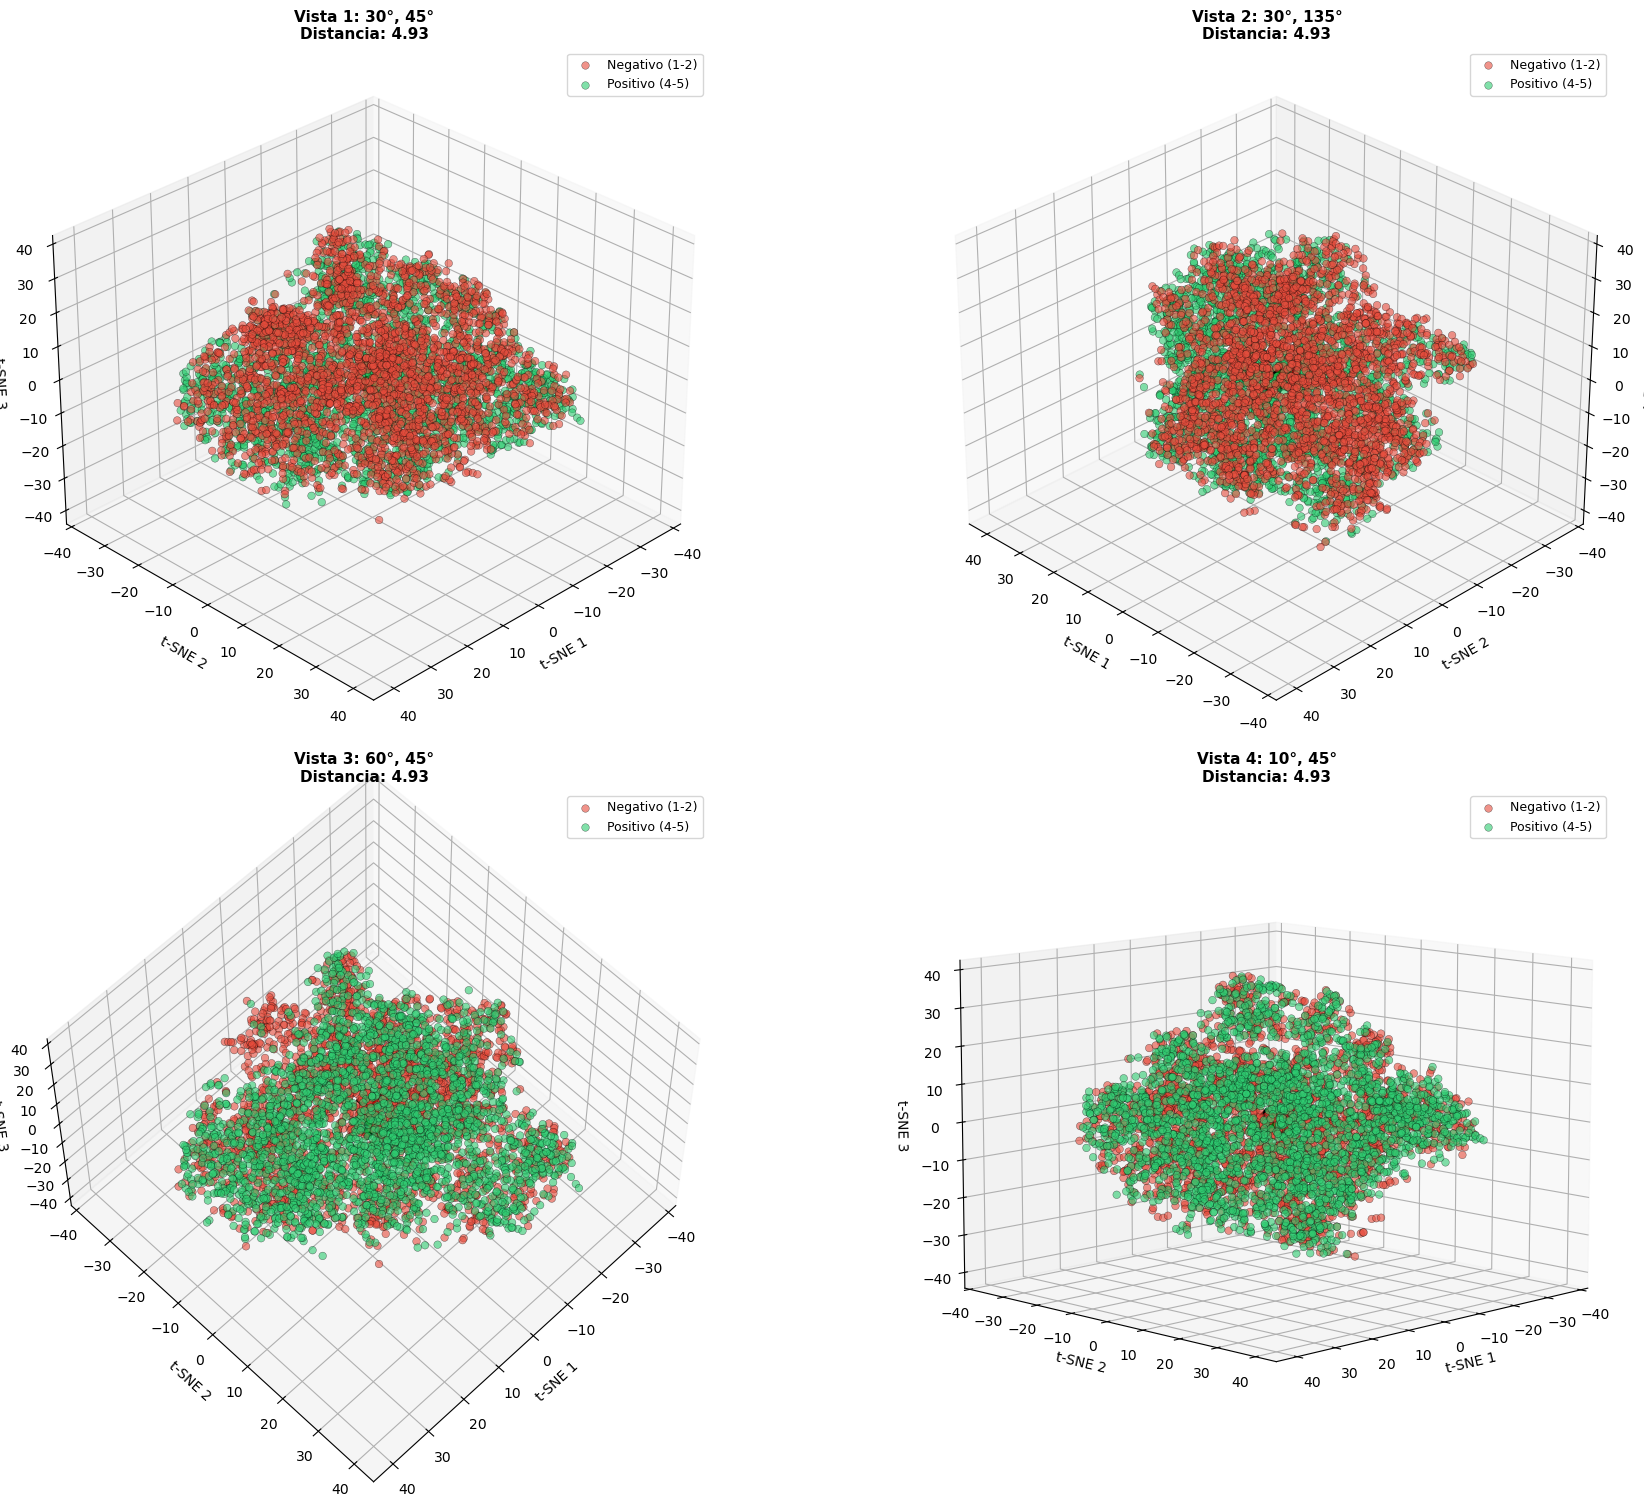

✓ Guardado: 'tsne_3d_clase.png'


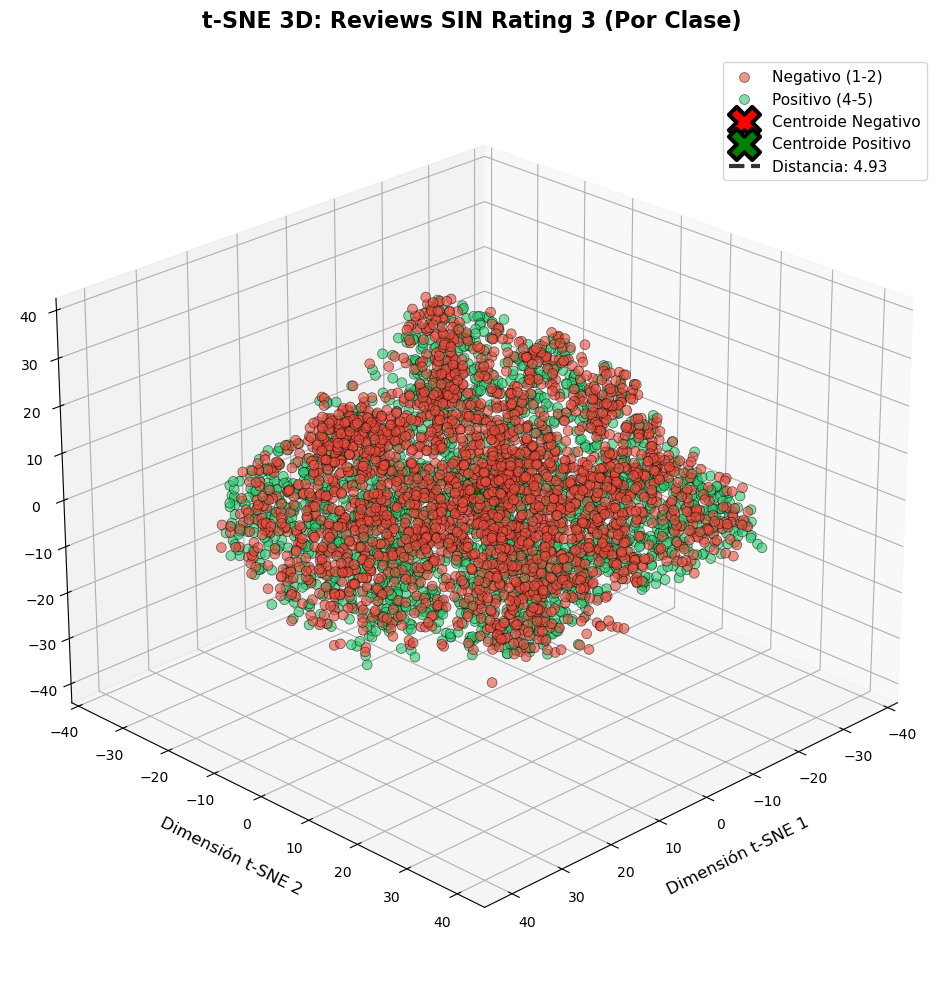

✓ Guardado: 'tsne_3d_rating.png'


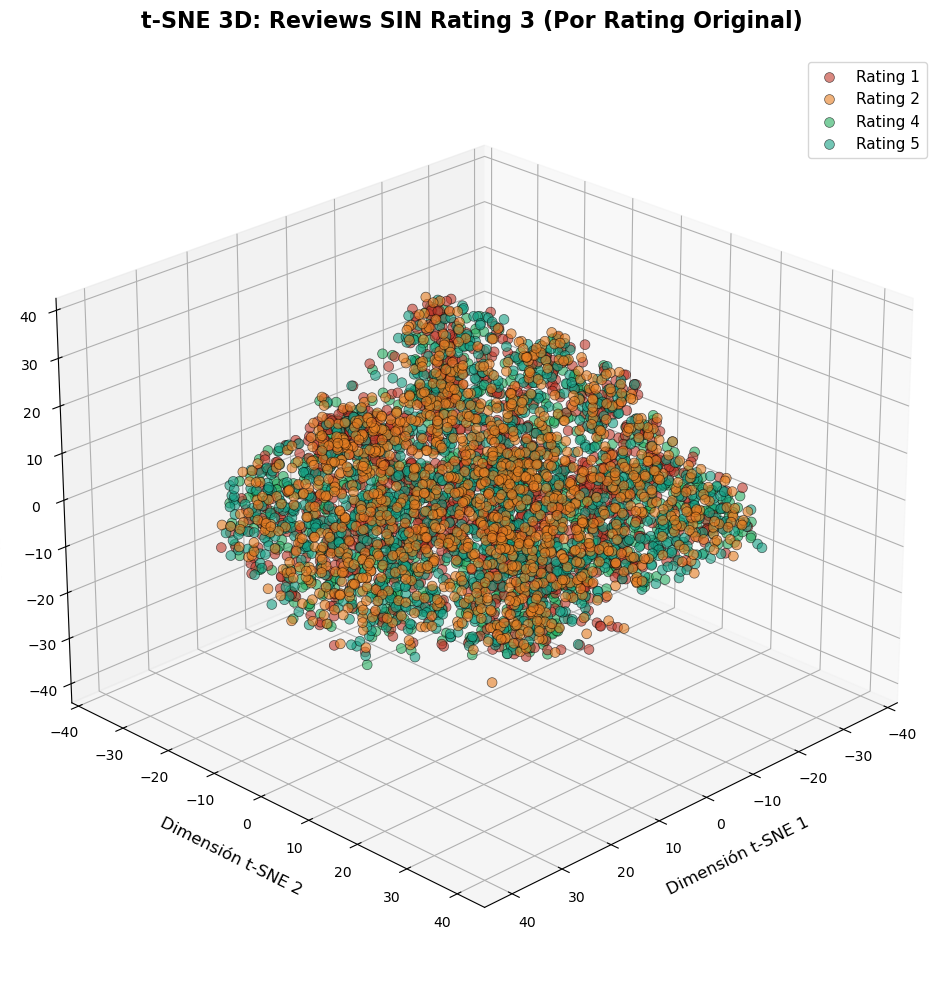

In [11]:
# ============================================
# 8. VISUALIZACIÓN 3D INTERACTIVA
# ============================================
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES 3D")
print("="*60)

# Colores
colors_clase = {0: '#e74c3c', 1: '#2ecc71'}
labels_clase = {0: 'Negativo (1-2)', 1: 'Positivo (4-5)'}
colors_rating = {1: '#c0392b', 2: '#e67e22', 4: '#27ae60', 5: '#16a085'}

# ===== FIGURA 1: Vista múltiple (4 ángulos) =====
fig = plt.figure(figsize=(20, 15))

angles = [
    (30, 45, "Vista 1: 30°, 45°"),
    (30, 135, "Vista 2: 30°, 135°"),
    (60, 45, "Vista 3: 60°, 45°"),
    (10, 45, "Vista 4: 10°, 45°")
]

for idx, (elev, azim, title) in enumerate(angles, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    for clase in [0, 1]:
        mask = df_tsne_3d['clase'] == clase
        ax.scatter(
            df_tsne_3d[mask]['x'],
            df_tsne_3d[mask]['y'],
            df_tsne_3d[mask]['z'],
            c=colors_clase[clase],
            label=labels_clase[clase],
            alpha=0.6,
            s=30,
            edgecolors='black',
            linewidth=0.3
        )
    
    # Centroides
    ax.scatter(centroid_0['x'], centroid_0['y'], centroid_0['z'],
              c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=5)
    ax.scatter(centroid_1['x'], centroid_1['y'], centroid_1['z'],
              c='green', marker='X', s=300, edgecolors='black', linewidth=2, zorder=5)
    
    # Línea entre centroides
    ax.plot([centroid_0['x'], centroid_1['x']],
            [centroid_0['y'], centroid_1['y']],
            [centroid_0['z'], centroid_1['z']],
            'k--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.set_zlabel('t-SNE 3', fontsize=10)
    ax.set_title(f'{title}\nDistancia: {distance_3d:.2f}', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.view_init(elev=elev, azim=azim)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_3d_multivista.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_3d_multivista.png'")
plt.show()

# ===== FIGURA 2: Por clase (vista óptima) =====
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for clase in [0, 1]:
    mask = df_tsne_3d['clase'] == clase
    ax.scatter(
        df_tsne_3d[mask]['x'],
        df_tsne_3d[mask]['y'],
        df_tsne_3d[mask]['z'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

# Centroides grandes
ax.scatter(centroid_0['x'], centroid_0['y'], centroid_0['z'],
          c='red', marker='X', s=500, edgecolors='black', linewidth=3, 
          label='Centroide Negativo', zorder=10)
ax.scatter(centroid_1['x'], centroid_1['y'], centroid_1['z'],
          c='green', marker='X', s=500, edgecolors='black', linewidth=3,
          label='Centroide Positivo', zorder=10)

# Línea entre centroides
ax.plot([centroid_0['x'], centroid_1['x']],
        [centroid_0['y'], centroid_1['y']],
        [centroid_0['z'], centroid_1['z']],
        'k--', linewidth=3, alpha=0.8, label=f'Distancia: {distance_3d:.2f}')

ax.set_xlabel('Dimensión t-SNE 1', fontsize=12, labelpad=10)
ax.set_ylabel('Dimensión t-SNE 2', fontsize=12, labelpad=10)
ax.set_zlabel('Dimensión t-SNE 3', fontsize=12, labelpad=10)
ax.set_title('t-SNE 3D: Reviews SIN Rating 3 (Por Clase)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.view_init(elev=25, azim=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_3d_clase.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_3d_clase.png'")
plt.show()

# ===== FIGURA 3: Por rating original =====
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for rating in sorted(df_tsne_3d['rating'].unique()):
    mask = df_tsne_3d['rating'] == rating
    ax.scatter(
        df_tsne_3d[mask]['x'],
        df_tsne_3d[mask]['y'],
        df_tsne_3d[mask]['z'],
        c=colors_rating[rating],
        label=f'Rating {rating}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Dimensión t-SNE 1', fontsize=12, labelpad=10)
ax.set_ylabel('Dimensión t-SNE 2', fontsize=12, labelpad=10)
ax.set_zlabel('Dimensión t-SNE 3', fontsize=12, labelpad=10)
ax.set_title('t-SNE 3D: Reviews SIN Rating 3 (Por Rating Original)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.view_init(elev=25, azim=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_3d_rating.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_3d_rating.png'")
plt.show()







✓ Guardado: 'tsne_3d_proyecciones.png'


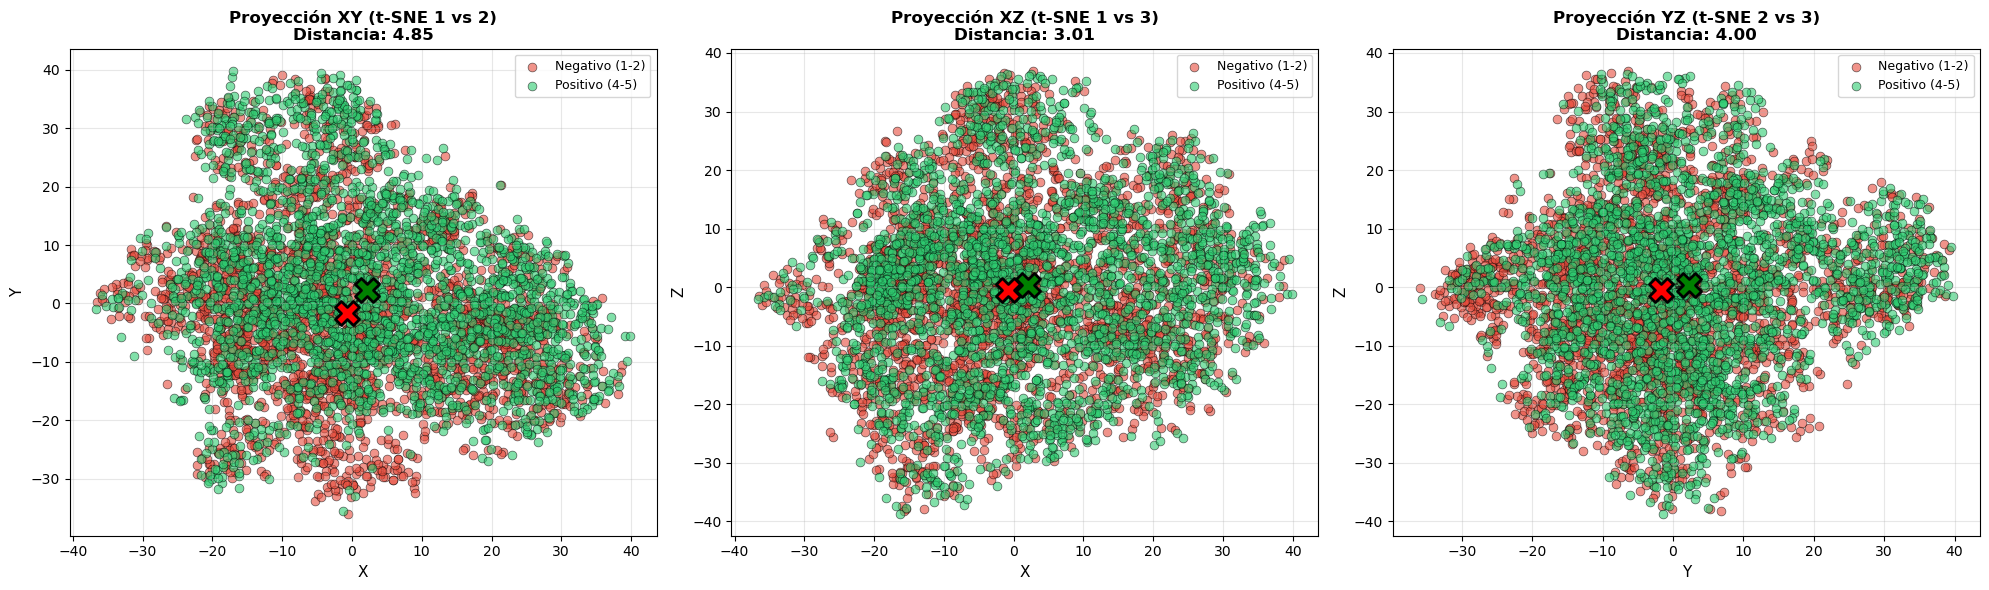

In [12]:
# ============================================
# 9. PROYECCIONES 2D (de 3D)
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

projections = [
    ('x', 'y', 'XY (t-SNE 1 vs 2)'),
    ('x', 'z', 'XZ (t-SNE 1 vs 3)'),
    ('y', 'z', 'YZ (t-SNE 2 vs 3)')
]

for idx, (dim1, dim2, title) in enumerate(projections):
    ax = axes[idx]
    
    for clase in [0, 1]:
        mask = df_tsne_3d['clase'] == clase
        ax.scatter(
            df_tsne_3d[mask][dim1],
            df_tsne_3d[mask][dim2],
            c=colors_clase[clase],
            label=labels_clase[clase],
            alpha=0.6,
            s=40,
            edgecolors='black',
            linewidth=0.5
        )
    
    # Centroides
    ax.scatter(centroid_0[dim1], centroid_0[dim2],
              c='red', marker='X', s=300, edgecolors='black', linewidth=2, zorder=5)
    ax.scatter(centroid_1[dim1], centroid_1[dim2],
              c='green', marker='X', s=300, edgecolors='black', linewidth=2, zorder=5)
    
    # Distancia en esta proyección
    dist_2d = np.sqrt((centroid_0[dim1] - centroid_1[dim1])**2 + 
                      (centroid_0[dim2] - centroid_1[dim2])**2)
    
    ax.plot([centroid_0[dim1], centroid_1[dim1]],
            [centroid_0[dim2], centroid_1[dim2]],
            'k--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel(f'{dim1.upper()}', fontsize=11)
    ax.set_ylabel(f'{dim2.upper()}', fontsize=11)
    ax.set_title(f'Proyección {title}\nDistancia: {dist_2d:.2f}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_3d_proyecciones.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_3d_proyecciones.png'")
plt.show()

In [13]:
# ============================================
# 10. ANIMACIÓN ROTATORIA (GIF)
# ============================================
print("\n📹 Generando animación rotatoria...")

from matplotlib.animation import FuncAnimation, PillowWriter

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Dibujar puntos
for clase in [0, 1]:
    mask = df_tsne_3d['clase'] == clase
    ax.scatter(
        df_tsne_3d[mask]['x'],
        df_tsne_3d[mask]['y'],
        df_tsne_3d[mask]['z'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.3
    )

# Centroides
ax.scatter(centroid_0['x'], centroid_0['y'], centroid_0['z'],
          c='red', marker='X', s=400, edgecolors='black', linewidth=3, zorder=10)
ax.scatter(centroid_1['x'], centroid_1['y'], centroid_1['z'],
          c='green', marker='X', s=400, edgecolors='black', linewidth=3, zorder=10)

ax.plot([centroid_0['x'], centroid_1['x']],
        [centroid_0['y'], centroid_1['y']],
        [centroid_0['z'], centroid_1['z']],
        'k--', linewidth=3, alpha=0.8)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title(f't-SNE 3D Rotación - Distancia: {distance_3d:.2f}', 
            fontsize=14, fontweight='bold')
ax.legend()

def rotate(frame):
    ax.view_init(elev=20, azim=frame)
    return fig,

anim = FuncAnimation(fig, rotate, frames=range(0, 360, 2), interval=50, blit=False)

try:
    writer = PillowWriter(fps=20)
    anim.save('tsne_3d_rotacion.gif', writer=writer)
    print("✓ Guardado: 'tsne_3d_rotacion.gif'")
except:
    print("⚠️ No se pudo guardar el GIF (instala Pillow: pip install Pillow)")

plt.close()


📹 Generando animación rotatoria...
✓ Guardado: 'tsne_3d_rotacion.gif'


In [14]:
# ============================================
# 11. RESUMEN FINAL
# ============================================
print("\n" + "="*60)
print("RESUMEN EJECUTIVO - t-SNE 3D")
print("="*60)

print(f"\n📊 DATOS:")
print(f"  • Reviews originales:        {len(df):,}")
print(f"  • Reviews filtradas:         {len(df_filtered):,}")
print(f"  • Muestra para t-SNE:        {len(df_sample):,}")

print(f"\n⏱️ TIEMPOS:")
print(f"  • TF-IDF:  {tfidf_time:.2f}s")
print(f"  • PCA:     {pca_time:.2f}s")
print(f"  • t-SNE:   {tsne_time:.2f}s")
print(f"  • TOTAL:   {tfidf_time + pca_time + tsne_time:.2f}s")

print(f"\n🎯 SEPARABILIDAD:")
print(f"  • Original (2D con rating 3):  2.34")
print(f"  • Nueva (3D sin rating 3):     {distance_3d:.2f}")
print(f"  • Mejora:                      {((distance_3d/2.34)-1)*100:+.1f}%")

print(f"\n📈 VENTAJAS DE 3D:")
print("  ✅ Mayor dimensionalidad = mejor preservación de distancias")
print("  ✅ Menos distorsión que 2D")
print("  ✅ Mejor visualización de clusters complejos")
print("  ⚠️ Más difícil de interpretar en papel (necesita rotación)")

print("\n✅ ARCHIVOS GENERADOS:")
print("  • tsne_3d_multivista.png       (4 ángulos diferentes)")
print("  • tsne_3d_clase.png            (por clase)")
print("  • tsne_3d_rating.png           (por rating)")
print("  • tsne_3d_proyecciones.png     (proyecciones 2D)")
print("  • tsne_3d_rotacion.gif         (animación rotatoria)")

print("\n" + "="*60)
print("SIGUIENTE PASO: Reentrenar Naive Bayes sin rating 3")
print("="*60)


RESUMEN EJECUTIVO - t-SNE 3D

📊 DATOS:
  • Reviews originales:        3,629,444
  • Reviews filtradas:         2,903,016
  • Muestra para t-SNE:        4,999

⏱️ TIEMPOS:
  • TF-IDF:  1.03s
  • PCA:     1.40s
  • t-SNE:   54.44s
  • TOTAL:   56.87s

🎯 SEPARABILIDAD:
  • Original (2D con rating 3):  2.34
  • Nueva (3D sin rating 3):     4.93
  • Mejora:                      +110.7%

📈 VENTAJAS DE 3D:
  ✅ Mayor dimensionalidad = mejor preservación de distancias
  ✅ Menos distorsión que 2D
  ✅ Mejor visualización de clusters complejos
  ⚠️ Más difícil de interpretar en papel (necesita rotación)

✅ ARCHIVOS GENERADOS:
  • tsne_3d_multivista.png       (4 ángulos diferentes)
  • tsne_3d_clase.png            (por clase)
  • tsne_3d_rating.png           (por rating)
  • tsne_3d_proyecciones.png     (proyecciones 2D)
  • tsne_3d_rotacion.gif         (animación rotatoria)

SIGUIENTE PASO: Reentrenar Naive Bayes sin rating 3
